```
GQA 유무에 따른 성능 비교
without MoE
+) 큰 모델로 비교
```

In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 200
HIDDEN_DIM = 200

BATCH_SIZE = 1024
EPOCHS = 10
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

# Hyperparameters for Transformer
NUM_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([1024, 64])
Target shape: torch.Size([1024, 64])
Sample 1: ------------------------------
Input sequence : , I prove a needless coward!What, shall we toward the Tower? th
Target sequence:  I prove a needless coward!What, shall we toward the Tower? the

Sample 2: ------------------------------
Input sequence : ly and personally accused,Her shall you hear disproved to her e
Target sequence: y and personally accused,Her shall you hear disproved to her ey

Sample 3: ------------------------------
Input sequence : l. He that dependsUpon your favours swims with fins of leadAnd
Target sequence: . He that dependsUpon your favours swims with fins of leadAnd 



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [19]:
def train_and_test(model_desc, model):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Model 1: Diff w/ MHA(w/o GQA)

In [20]:
@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = HIDDEN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # x: [B, L, n_kv, d]
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.w1 = nn.Linear(dim, ffn_dim, bias=False)
        self.w2 = nn.Linear(ffn_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, ffn_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class DiffSelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, depth=0):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep  # typically n_heads // n_kv_heads
        self.head_dim = dim // n_heads  # standard head dimension

        # For diff attention, project Q to 2*n_heads*head_dim,
        # and K, V to 2*n_kv_heads*head_dim.
        self.wq = nn.Linear(dim, 2 * n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        # Output projection expects input dim = 2*n_heads*head_dim.
        self.wo = nn.Linear(2 * n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout

        # Lambda parameter as in diff attention paper.
        self.lambda_init = 0.8 - 0.6 * math.exp(-0.3 * depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        
        # groupnorm
        self.norm = RMSNorm(2*self.head_dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos # same with start_pos
        
        # Project and reshape: 
        xq = self.wq(x).view(B, trg_len, 2 * self.n_heads_q, self.head_dim)   # [B, L, 2*heads, head_dim]
        xk = self.wk(x).view(B, src_len, 2 * self.n_kv_heads, self.head_dim)  # [B, L, 2*heads_kv, head_dim]
        xv = self.wv(x).view(B, src_len, self.n_kv_heads, 2 * self.head_dim)  # [B, L, heads_kv, 2*head_dim]
        
        # Apply rotary embeddings on queries and keys.
        xq = apply_rotary_emb(xq, device=x.device)
        xk = apply_rotary_emb(xk, device=x.device)
        
        # Grouped Query Attention:
        xq = xq.transpose(1, 2)                         # [B, 2*heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        
        # scaling
        scaling = 1 / math.sqrt(self.head_dim)
        xq *= scaling
        
        attn_weights = torch.matmul(xq, xk.transpose(-1, -2))
        
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += mask
        attn_weights = F.softmax(attn_weights, dim=-1).type_as(attn_weights)
        attn_weights = attn_weights.view(B, self.n_heads_q, 2, trg_len, src_len)
        
        # Combine the two attention scores with lambda.
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(xq)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(xq)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        
        attn1 = attn_weights[:,:,0]
        attn2 = attn_weights[:,:,1]
        
        attn_weights = attn1 - lambda_full * attn2
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        
        # Compute attention output.
        attn = torch.matmul(attn_weights, xv)
        attn = self.norm(attn)
        attn = attn * (1-self.lambda_init)
        attn = attn.transpose(1, 2).contiguous().view(B, L, -1)
        attn_output = self.wo(attn)
        
        if return_attn:
            # Return four maps:
            # [첫 번째 맵(attn1), 두 번째 맵(attn2), 두 번째 맵에 람다를 곱한 결과, 최종 결과(attn_weights)]
            return attn_output, [attn1, attn2, lambda_full*attn2, attn_weights]
        else:
            return attn_output

class TransformerBlock(nn.Module):
    def __init__(self, args, depth: int = 0):
        super().__init__()
        self.attn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.attention = DiffSelfAttention(
            n_heads=args.NUM_HEADS,
            n_kv_heads=args.NUM_KV_HEADS if args.NUM_KV_HEADS is not None else args.NUM_HEADS,
            n_rep=args.NUM_KV_HEAD_REP,
            dim=args.DIM,
            dropout=args.DROPOUT,
            depth=depth
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attn_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attn_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class DiffTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args, depth=i) for i in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE

    def forward(self, x: torch.Tensor, start_pos: int = 0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, DIM]
        mask = None
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [21]:
PARAMS = ModelArgs()
diff1 = DiffTransformer(PARAMS).to(device)
diff1

DiffTransformer(
  (tok_embeddings): Embedding(65, 200)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=200, out_features=400, bias=False)
        (wk): Linear(in_features=200, out_features=400, bias=False)
        (wv): Linear(in_features=200, out_features=400, bias=False)
        (wo): Linear(in_features=400, out_features=200, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=200, out_features=200, bias=False)
        (w2): Linear(in_features=200, out_features=200, bias=False)
        (w3): Linear(in_features=200, out_features=200, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=200, out_features=65, bias=False)
)

In [22]:
from torchinfo import summary

# Describe the model
summary(diff1.to('cuda:0'), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [1024, 64, 65]            --
├─Embedding: 1-1                         [1024, 64, 200]           13,000
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1024, 64, 200]           --
│    │    └─RMSNorm: 3-1                 [1024, 64, 200]           200
│    │    └─DiffSelfAttention: 3-2       [1024, 64, 200]           320,300
│    │    └─Dropout: 3-3                 [1024, 64, 200]           --
│    │    └─RMSNorm: 3-4                 [1024, 64, 200]           200
│    │    └─FeedForward: 3-5             [1024, 64, 200]           120,000
│    │    └─Dropout: 3-6                 [1024, 64, 200]           --
│    └─TransformerBlock: 2-2             [1024, 64, 200]           --
│    │    └─RMSNorm: 3-7                 [1024, 64, 200]           200
│    │    └─DiffSelfAttention: 3-8       [1024, 64, 200]           3

Epoch 1/10, Train Loss: 1.6096, Val Loss: 1.8061, Epoch Time: 112.34s Average Vram Usage: 60.83MB


Epoch 2/10, Train Loss: 1.4390, Val Loss: 1.7643, Epoch Time: 112.41s Average Vram Usage: 60.83MB


Epoch 3/10, Train Loss: 1.4288, Val Loss: 1.7244, Epoch Time: 112.49s Average Vram Usage: 60.83MB


Epoch 4/10, Train Loss: 1.3700, Val Loss: 1.7220, Epoch Time: 100.28s Average Vram Usage: 60.83MB


Epoch 5/10, Train Loss: 1.3554, Val Loss: 1.7231, Epoch Time: 102.48s Average Vram Usage: 60.83MB


Epoch 6/10, Train Loss: 1.3028, Val Loss: 1.7431, Epoch Time: 122.50s Average Vram Usage: 60.83MB


Epoch 7/10, Train Loss: 1.3125, Val Loss: 1.7315, Epoch Time: 123.05s Average Vram Usage: 60.83MB


Epoch 8/10, Train Loss: 1.2708, Val Loss: 1.7391, Epoch Time: 112.47s Average Vram Usage: 60.83MB


Epoch 9/10, Train Loss: 1.2768, Val Loss: 1.7348, Epoch Time: 108.89s Average Vram Usage: 60.83MB


Epoch 10/10, Train Loss: 1.2555, Val Loss: 1.7388, Epoch Time: 96.92s Average Vram Usage: 60.83MB


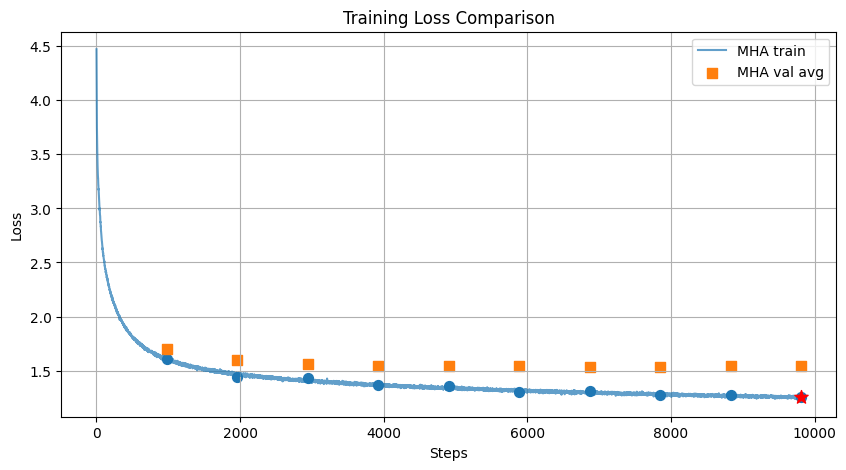

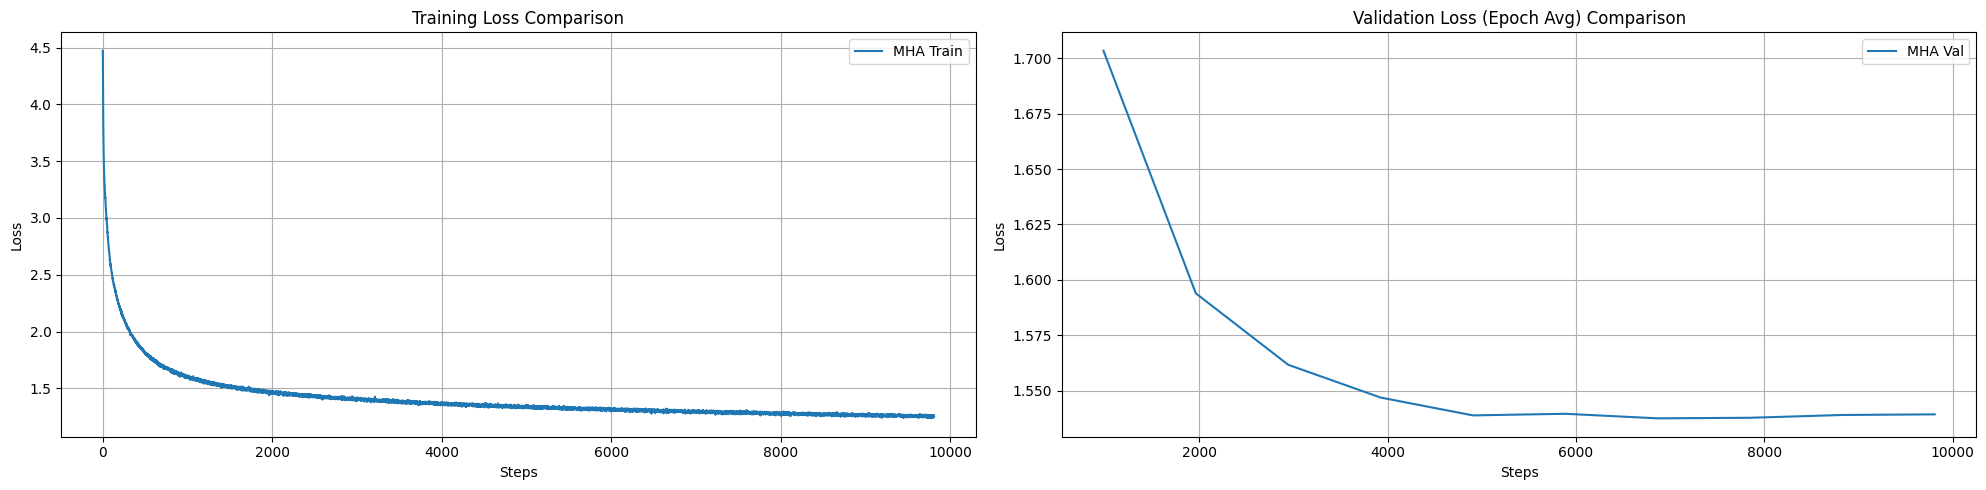

In [23]:
train_and_test("MHA", diff1)

## Model 2: Diff w/ GQA(groups=2)

In [ ]:
PARAMS.NUM_KV_HEAD_REP = 2
PARAMS.NUM_KV_HEADS = PARAMS.NUM_HEADS // PARAMS.NUM_KV_HEAD_REP

In [25]:
PARAMS = ModelArgs()
diff2 = DiffTransformer(PARAMS).to(device)
diff2

DiffTransformer(
  (tok_embeddings): Embedding(65, 200)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=200, out_features=400, bias=False)
        (wk): Linear(in_features=200, out_features=200, bias=False)
        (wv): Linear(in_features=200, out_features=200, bias=False)
        (wo): Linear(in_features=400, out_features=200, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=200, out_features=200, bias=False)
        (w2): Linear(in_features=200, out_features=200, bias=False)
        (w3): Linear(in_features=200, out_features=200, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=200, out_features=65, bias=False)
)

In [26]:
from torchinfo import summary

# Describe the model
summary(diff2.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [1024, 64, 65]            --
├─Embedding: 1-1                         [1024, 64, 200]           13,000
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1024, 64, 200]           --
│    │    └─RMSNorm: 3-1                 [1024, 64, 200]           200
│    │    └─DiffSelfAttention: 3-2       [1024, 64, 200]           240,300
│    │    └─Dropout: 3-3                 [1024, 64, 200]           --
│    │    └─RMSNorm: 3-4                 [1024, 64, 200]           200
│    │    └─FeedForward: 3-5             [1024, 64, 200]           120,000
│    │    └─Dropout: 3-6                 [1024, 64, 200]           --
│    └─TransformerBlock: 2-2             [1024, 64, 200]           --
│    │    └─RMSNorm: 3-7                 [1024, 64, 200]           200
│    │    └─DiffSelfAttention: 3-8       [1024, 64, 200]           2

Epoch 1/10, Train Loss: 1.6122, Val Loss: 1.8375, Epoch Time: 169.67s Average Vram Usage: 69.62MB


Epoch 2/10, Train Loss: 1.4539, Val Loss: 1.7774, Epoch Time: 174.71s Average Vram Usage: 69.62MB


Epoch 3/10, Train Loss: 1.4028, Val Loss: 1.7442, Epoch Time: 174.64s Average Vram Usage: 69.62MB


Epoch 4/10, Train Loss: 1.3973, Val Loss: 1.7349, Epoch Time: 175.37s Average Vram Usage: 69.62MB


Epoch 5/10, Train Loss: 1.3360, Val Loss: 1.7470, Epoch Time: 174.63s Average Vram Usage: 69.62MB


Epoch 6/10, Train Loss: 1.3115, Val Loss: 1.7360, Epoch Time: 174.12s Average Vram Usage: 69.62MB


Epoch 7/10, Train Loss: 1.3262, Val Loss: 1.7484, Epoch Time: 173.18s Average Vram Usage: 69.62MB


Epoch 8/10, Train Loss: 1.2904, Val Loss: 1.7530, Epoch Time: 171.48s Average Vram Usage: 69.62MB


Epoch 9/10, Train Loss: 1.2913, Val Loss: 1.7688, Epoch Time: 172.70s Average Vram Usage: 69.62MB


Epoch 10/10, Train Loss: 1.2656, Val Loss: 1.7727, Epoch Time: 172.96s Average Vram Usage: 69.62MB


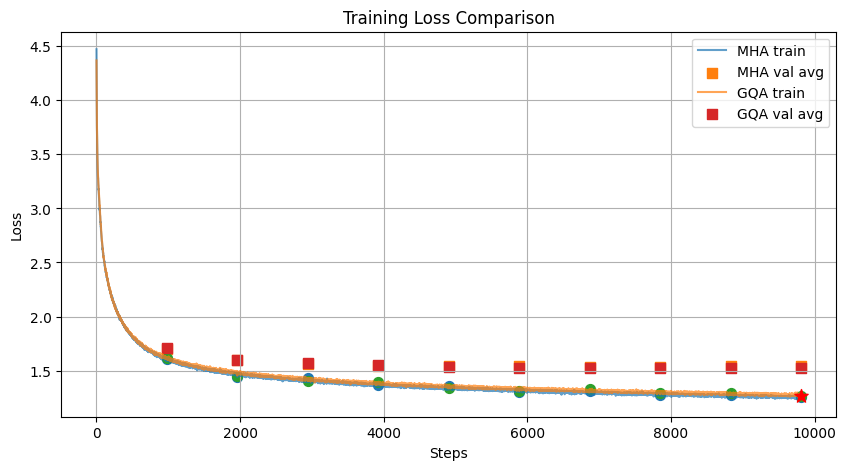

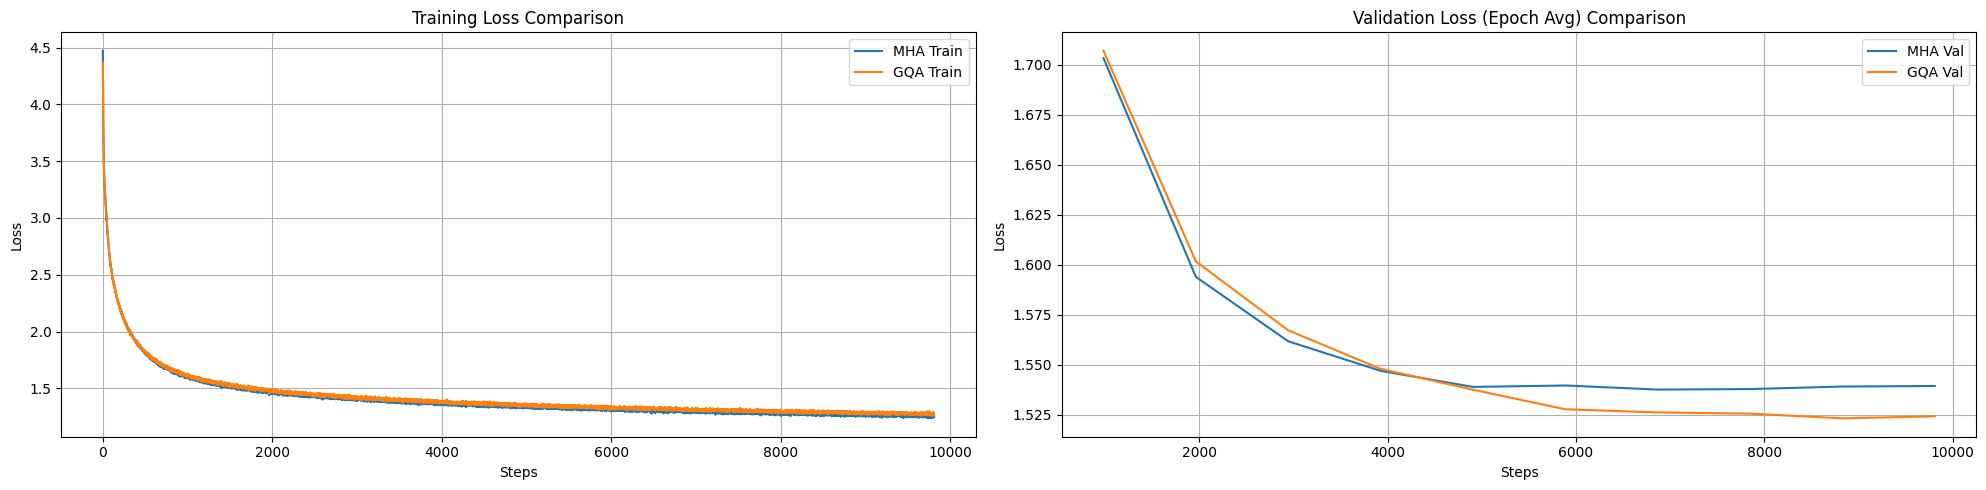

In [27]:
train_and_test("GQA", diff2)